# Topic Trends - Pandemics

This code was created from Martha and Sean's emerging topic code. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

### Data Ingestion

In [2]:
# pandemic corpus
df = pd.read_pickle("../../../data/prd/Paper/case_studies/pandemic_corpus.pkl")
df.reset_index(inplace=True, drop = True)

In [3]:
df.shape

(7571, 30)

In [4]:
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,90045,Study of Emerging Networks in Outbreak Respons...,Arts; Communicable Diseases; Communication; Co...,STUDY OF EMERGING NETWORKS IN OUTBREAK RESPONSE,NSF,NSF,NaN,0826995,9/15/2008,8/31/2012,"ANSELL, CHRISTOPHER","KELLER, ANN; REINGOLD, ARTHUR",09,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.075,2008,726706.0,NaN,1,1,726706.0,1,study emerging networks outbreak responseprinc...
1,90243,One of the products of human development and p...,Affect; Agriculture; anthropogenesis; Award; b...,HSD: COLLABORATIVE RESEARCH: HUMAN-RELATED FAC...,NSF,NSF,NaN,0826779,10/1/2008,3/31/2012,"DASZAK, PETER","KILPATRICK, A MARM",08,077090066,ECOHEALTH ALLIANCE INC,NEW YORK,NY,10001-2320,UNITED STATES,NaN,NaN,47.075,2008,468673.0,NaN,2,2,700001.0,2,product human development population growth gl...
2,90573,Intellectual merit:The proposed project seeks ...,base; Basic Science; Biological; Biology; Bird...,COMBINING ECOLOGICAL AND MOLECULAR MODELS TO U...,NSF,NSF,NaN,0827416,9/1/2008,8/31/2011,"KOELLE, KATHARINA",NaN,04,044387793,DUKE UNIVERSITY,DURHAM,NC,27705-4010,UNITED STATES,NaN,NaN,47.074,2008,610071.0,NaN,1,1,610071.0,1,intellectual_merit propose project seek develo...
3,91397,West Nile virus re-emerges annually in urban s...,Birds; Chicago; Culicidae; Disease; Environmen...,WEST NILE VIRUS: ECO-EPIDEMIOLOGY OF DISEASE E...,NSF,NSF,NaN,0840403,9/1/2008,8/31/2012,"GOLDBERG, TONY L.","BRAWN, JEFFREY; RUIZ, MARILYN; KITRON, URIEL; ...",02,003255648,UNIVERSITY OF WISCONSIN SYSTEM,MADISON,WI,53715-1218,UNITED STATES,NaN,NaN,47.074,2008,1964529.0,NaN,1,1,1964529.0,1,west_nile virus emerge annually urban setting ...
4,93669,About five percent of the world's population d...,Affect; Disabled Persons; Disease; Emerging Co...,RESEARCH STARTER: POPULATION DYNAMICS AND EVOL...,NSF,NSF,NaN,0804039,8/1/2008,7/31/2010,"DENNEHY, JOHN J",NaN,09,064932676,RESEARCH FOUNDATION OF THE CITY UNIVERSITY OF ...,FLUSHING,NY,11367-1575,UNITED STATES,NaN,NaN,47.074,2008,67848.0,NaN,1,1,67848.0,1,percent world population die major influenza p...


In [5]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

### Functions needed for all models

In [6]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [7]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF

In [8]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [52]:
# create model

num_topics = 20

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 7.714603424072266


/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [53]:
print_topics(topic_term, tfidf_vectorizer, 20)


Topic 0:
('virus', 4.044410314692751)
('human', 0.8023040523954178)
('infection', 0.3831224526774771)
('genetic', 0.3796987282660229)
('transmission', 0.37392711977297505)
('host', 0.36975072688100513)
('mutation', 0.3609747484589347)
('cause', 0.35465399993913826)
('viral', 0.3249063910279877)
('infect', 0.30701560430037594)
('swine', 0.28788160407625174)
('attenuate', 0.2748885212571133)
('model', 0.26913105681305655)
('isolate', 0.25952395451616583)
('gene', 0.2570145212459988)
('replication', 0.25492456878854813)
('disease', 0.2531338882673313)
('h5n1', 0.25292174422063335)
('avian_influenza', 0.2518251837073965)
('emerge', 0.24593007734508487)

Topic 1:
('social', 0.8722390300839148)
('covid_19', 0.8182751281491557)
('health', 0.8122035759498292)
('datum', 0.8013395873870087)
('community', 0.6649153932978991)
('behavior', 0.5678267535618822)
('intervention', 0.5543579596521817)
('risk', 0.5379564268988942)
('public', 0.5201627874768336)
('model', 0.50558354147129)
('information',

### Topic Trends

In [54]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [55]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,0.000000,0.054451,0.000000,0.003604,0.000000,0.003551,0.000000,0.003803,0.010554,0.009445,0.000000,0.001405,0.000000,0.005410,0.000000,0.000000,0.008547,0.009593,0.0,0.050933,2008
1,0.003868,0.058181,0.000000,0.004658,0.000000,0.000000,0.000000,0.019264,0.035460,0.029589,0.013696,0.000000,0.000000,0.008471,0.000000,0.000000,0.015070,0.001588,0.0,0.000000,2008
2,0.006208,0.029578,0.015616,0.004781,0.006059,0.000000,0.000000,0.006903,0.030844,0.003797,0.000000,0.011682,0.005174,0.001539,0.000000,0.063033,0.008691,0.003840,0.0,0.000000,2008
3,0.034918,0.018973,0.000000,0.000000,0.000000,0.000000,0.000968,0.017023,0.001210,0.000000,0.000000,0.000000,0.000000,0.004911,0.000000,0.005816,0.033920,0.024339,0.0,0.000000,2008
4,0.035840,0.019481,0.011041,0.000000,0.000000,0.000000,0.000000,0.005776,0.028462,0.007114,0.000166,0.003157,0.000000,0.000000,0.000000,0.007701,0.000000,0.000000,0.0,0.000000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7566,0.000000,0.046228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2020
7567,0.014768,0.093788,0.000000,0.003210,0.000000,0.000000,0.000000,0.004635,0.000368,0.000000,0.009891,0.000000,0.000000,0.012733,0.014567,0.000000,0.000000,0.000000,0.0,0.000000,2020
7568,0.000000,0.050037,0.000000,0.000000,0.000000,0.000851,0.000000,0.000000,0.052236,0.000000,0.000315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2020
7569,0.004156,0.080038,0.000000,0.000000,0.000000,0.000000,0.003609,0.000408,0.018671,0.008349,0.002010,0.000000,0.000000,0.000000,0.027498,0.000000,0.005201,0.000000,0.0,0.000000,2020


#### compute count of projects with weight > 0 for each topic

In [56]:
topic_proj_count = topic_frame.copy()

In [57]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,0.000000,0.054451,0.000000,0.003604,0.000000,0.003551,0.000000,0.003803,0.010554,0.009445,0.000000,0.001405,0.000000,0.005410,0.0,0.000000,0.008547,0.009593,0.0,0.050933,2008
1,0.003868,0.058181,0.000000,0.004658,0.000000,0.000000,0.000000,0.019264,0.035460,0.029589,0.013696,0.000000,0.000000,0.008471,0.0,0.000000,0.015070,0.001588,0.0,0.000000,2008
2,0.006208,0.029578,0.015616,0.004781,0.006059,0.000000,0.000000,0.006903,0.030844,0.003797,0.000000,0.011682,0.005174,0.001539,0.0,0.063033,0.008691,0.003840,0.0,0.000000,2008
3,0.034918,0.018973,0.000000,0.000000,0.000000,0.000000,0.000968,0.017023,0.001210,0.000000,0.000000,0.000000,0.000000,0.004911,0.0,0.005816,0.033920,0.024339,0.0,0.000000,2008
4,0.035840,0.019481,0.011041,0.000000,0.000000,0.000000,0.000000,0.005776,0.028462,0.007114,0.000166,0.003157,0.000000,0.000000,0.0,0.007701,0.000000,0.000000,0.0,0.000000,2008


In [58]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [59]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,False,True,False,True,False,True,False,True,True,True,False,True,False,True,False,False,True,True,False,True,2008
1,True,True,False,True,False,False,False,True,True,True,True,False,False,True,False,False,True,True,False,False,2008
2,True,True,True,True,True,False,False,True,True,True,False,True,True,True,False,True,True,True,False,False,2008
3,True,True,False,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,False,False,2008
4,True,True,True,False,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False,False,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7566,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2020
7567,True,True,False,True,False,False,False,True,True,False,True,False,False,True,True,False,False,False,False,False,2020
7568,False,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,2020
7569,True,True,False,False,False,False,True,True,True,True,True,False,False,False,True,False,True,False,False,False,2020


In [60]:
topic_count_bool.sum(axis=1).median()

9.0

In [61]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [62]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,350,237,244,307,220,238,183,220,197,244,217,150,218,260,132,257,259,169,153,170
1,2009,403,293,285,338,257,277,206,246,257,292,263,189,247,290,161,289,274,183,178,223
2,2010,373,276,298,336,259,301,205,259,255,300,245,205,227,280,165,272,255,165,181,210
3,2011,347,273,282,315,260,290,198,262,248,288,252,184,213,264,158,276,248,153,172,204
4,2012,293,236,229,256,213,223,158,232,213,265,208,159,178,242,135,240,202,147,142,170
5,2013,259,193,212,228,189,236,142,204,187,258,196,133,176,214,130,214,197,127,132,153
6,2014,240,184,188,227,174,216,130,204,168,240,193,137,186,214,113,198,183,110,124,135
7,2015,260,216,217,258,180,229,144,210,166,250,197,147,195,229,106,216,207,118,140,157
8,2016,271,227,229,241,198,214,154,208,178,238,207,160,185,245,120,227,198,136,156,168
9,2017,265,214,230,252,191,231,161,220,177,242,213,164,192,232,127,250,204,137,161,162


In [63]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [64]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [65]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,350,237,244,307,220,238,183,220,197,244,217,150,218,260,132,257,259,169,153,170
1,2009,403,293,285,338,257,277,206,246,257,292,263,189,247,290,161,289,274,183,178,223
2,2010,373,276,298,336,259,301,205,259,255,300,245,205,227,280,165,272,255,165,181,210
3,2011,347,273,282,315,260,290,198,262,248,288,252,184,213,264,158,276,248,153,172,204
4,2012,293,236,229,256,213,223,158,232,213,265,208,159,178,242,135,240,202,147,142,170
5,2013,259,193,212,228,189,236,142,204,187,258,196,133,176,214,130,214,197,127,132,153
6,2014,240,184,188,227,174,216,130,204,168,240,193,137,186,214,113,198,183,110,124,135
7,2015,260,216,217,258,180,229,144,210,166,250,197,147,195,229,106,216,207,118,140,157
8,2016,271,227,229,241,198,214,154,208,178,238,207,160,185,245,120,227,198,136,156,168
9,2017,265,214,230,252,191,231,161,220,177,242,213,164,192,232,127,250,204,137,161,162


In [66]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     4368
Topic 1     4345
Topic 2     3431
Topic 3     4217
Topic 4     3185
Topic 5     3815
Topic 6     2526
Topic 7     3442
Topic 8     3489
Topic 9     3918
Topic 10    3579
Topic 11    2483
Topic 12    3230
Topic 13    4090
Topic 14    2913
Topic 15    3811
Topic 16    3471
Topic 17    2267
Topic 18    2706
Topic 19    2661
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [67]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [68]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [69]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.016065,0.007074,0.019150,0.021172,0.012400,0.012632,0.009672,0.005825,0.006842,0.010046,0.009938,0.001914,0.007430,0.011006,0.001545,0.016267,0.007548,0.004067,0.003147,0.006075
1,2009,0.016014,0.006486,0.018162,0.020156,0.011326,0.013171,0.008557,0.006454,0.008126,0.011728,0.009980,0.002117,0.006906,0.012001,0.001700,0.015546,0.006427,0.004251,0.002824,0.005866
2,2010,0.013819,0.006691,0.019332,0.020303,0.011841,0.015337,0.007951,0.005779,0.009124,0.012905,0.009395,0.002646,0.007457,0.011623,0.001645,0.014369,0.005032,0.003237,0.003283,0.006324
3,2011,0.013776,0.006555,0.019239,0.019956,0.013200,0.015100,0.008720,0.006293,0.011026,0.011901,0.009616,0.002675,0.007494,0.010955,0.001458,0.015388,0.006724,0.002508,0.003511,0.006033
4,2012,0.014236,0.006737,0.017840,0.019120,0.014744,0.013225,0.007175,0.007334,0.011170,0.013638,0.009285,0.003150,0.008185,0.011664,0.001475,0.015596,0.007094,0.002827,0.003819,0.005361
5,2013,0.013275,0.005752,0.018282,0.017713,0.012092,0.014784,0.007712,0.006333,0.010899,0.013852,0.009706,0.004234,0.009127,0.010006,0.001623,0.016222,0.006283,0.003304,0.003871,0.004758
6,2014,0.013168,0.006712,0.017518,0.019672,0.012543,0.013130,0.007387,0.006956,0.009667,0.013019,0.008989,0.004783,0.010803,0.010102,0.001395,0.015433,0.005363,0.002323,0.004700,0.005696
7,2015,0.012705,0.007281,0.018414,0.020693,0.010376,0.013208,0.006878,0.006722,0.007963,0.013254,0.007414,0.006635,0.010759,0.009053,0.001186,0.015666,0.005110,0.002679,0.004960,0.012047
8,2016,0.012506,0.006466,0.018031,0.018171,0.011802,0.012571,0.005917,0.006555,0.008119,0.012783,0.007835,0.008626,0.010723,0.009561,0.001297,0.016473,0.006462,0.007089,0.004587,0.007660
9,2017,0.010546,0.005313,0.016478,0.016793,0.010876,0.012839,0.006033,0.006235,0.008082,0.013112,0.008453,0.009538,0.011447,0.008694,0.001355,0.017330,0.006099,0.012136,0.004683,0.006985


In [70]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [71]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.016065,0.007074,0.019150,0.021172,0.012400,0.012632,0.009672,0.005825,0.006842,0.010046,0.009938,0.001914,0.007430,0.011006,0.001545,0.016267,0.007548,0.004067,0.003147,0.006075
1,2009,0.016014,0.006486,0.018162,0.020156,0.011326,0.013171,0.008557,0.006454,0.008126,0.011728,0.009980,0.002117,0.006906,0.012001,0.001700,0.015546,0.006427,0.004251,0.002824,0.005866
2,2010,0.013819,0.006691,0.019332,0.020303,0.011841,0.015337,0.007951,0.005779,0.009124,0.012905,0.009395,0.002646,0.007457,0.011623,0.001645,0.014369,0.005032,0.003237,0.003283,0.006324
3,2011,0.013776,0.006555,0.019239,0.019956,0.013200,0.015100,0.008720,0.006293,0.011026,0.011901,0.009616,0.002675,0.007494,0.010955,0.001458,0.015388,0.006724,0.002508,0.003511,0.006033
4,2012,0.014236,0.006737,0.017840,0.019120,0.014744,0.013225,0.007175,0.007334,0.011170,0.013638,0.009285,0.003150,0.008185,0.011664,0.001475,0.015596,0.007094,0.002827,0.003819,0.005361
5,2013,0.013275,0.005752,0.018282,0.017713,0.012092,0.014784,0.007712,0.006333,0.010899,0.013852,0.009706,0.004234,0.009127,0.010006,0.001623,0.016222,0.006283,0.003304,0.003871,0.004758
6,2014,0.013168,0.006712,0.017518,0.019672,0.012543,0.013130,0.007387,0.006956,0.009667,0.013019,0.008989,0.004783,0.010803,0.010102,0.001395,0.015433,0.005363,0.002323,0.004700,0.005696
7,2015,0.012705,0.007281,0.018414,0.020693,0.010376,0.013208,0.006878,0.006722,0.007963,0.013254,0.007414,0.006635,0.010759,0.009053,0.001186,0.015666,0.005110,0.002679,0.004960,0.012047
8,2016,0.012506,0.006466,0.018031,0.018171,0.011802,0.012571,0.005917,0.006555,0.008119,0.012783,0.007835,0.008626,0.010723,0.009561,0.001297,0.016473,0.006462,0.007089,0.004587,0.007660
9,2017,0.010546,0.005313,0.016478,0.016793,0.010876,0.012839,0.006033,0.006235,0.008082,0.013112,0.008453,0.009538,0.011447,0.008694,0.001355,0.017330,0.006099,0.012136,0.004683,0.006985


In [72]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.000849,0.000616,0.001332,0.001435,0.001372,0.001271,0.001244,0.001035,0.000855,0.000839,0.001116,0.000491,0.000832,0.001071,0.000173,0.001322,0.001376,0.000645,0.000623,0.001211
1,2009,0.000778,0.000547,0.001234,0.001354,0.001186,0.001181,0.001101,0.001076,0.000961,0.000854,0.001038,0.000451,0.000724,0.001119,0.000183,0.001238,0.001029,0.000665,0.000330,0.001043
2,2010,0.000736,0.000570,0.001283,0.001377,0.001183,0.001298,0.001032,0.000875,0.001080,0.000928,0.001001,0.000507,0.000795,0.001115,0.000166,0.001178,0.000480,0.000543,0.000447,0.001257
3,2011,0.000762,0.000568,0.001317,0.001384,0.001293,0.001296,0.001127,0.000927,0.001237,0.000904,0.001061,0.000620,0.000804,0.001166,0.000149,0.001237,0.001097,0.000446,0.000580,0.001239
4,2012,0.000888,0.000621,0.001428,0.001464,0.001484,0.001292,0.001096,0.001231,0.001355,0.001003,0.001062,0.000743,0.001002,0.001289,0.000182,0.001307,0.001312,0.000522,0.000679,0.001194
5,2013,0.000855,0.000620,0.001459,0.001424,0.001383,0.001373,0.001222,0.001150,0.001457,0.001018,0.001093,0.001029,0.001095,0.001157,0.000197,0.001478,0.001331,0.000650,0.000743,0.001054
6,2014,0.000918,0.000688,0.001464,0.001540,0.001477,0.001261,0.001212,0.001253,0.001400,0.001030,0.000990,0.001091,0.001258,0.001267,0.000190,0.001436,0.000975,0.000434,0.000930,0.001306
7,2015,0.000835,0.000706,0.001451,0.001533,0.001349,0.001203,0.001092,0.001136,0.001192,0.001051,0.000916,0.001376,0.001164,0.001142,0.000166,0.001389,0.000876,0.000488,0.000884,0.002128
8,2016,0.000792,0.000622,0.001412,0.001405,0.001452,0.001202,0.001013,0.001124,0.001183,0.001025,0.000957,0.001587,0.001186,0.001081,0.000161,0.001451,0.001540,0.001532,0.000774,0.001554
9,2017,0.000713,0.000538,0.001340,0.001334,0.001349,0.001167,0.001010,0.001087,0.001183,0.001043,0.001005,0.001653,0.001124,0.000923,0.000168,0.001453,0.001500,0.002254,0.000793,0.001380


In [73]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [74]:
topic_slopes[:5]

[-0.0007194353154603725,
 0.0006171706141388609,
 -0.0005039425806354599,
 -0.0006563083720035758,
 -0.0004234895242051769]

In [75]:
p_values[:5]

[2.6174281933758566e-05,
 0.17730450958503086,
 0.08219655934500295,
 0.005748989863074124,
 0.013885713938139052]

In [76]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [77]:
leg[:5]

['virus, human, infection, genetic, transmission',
 'social, covid_19, health, datum, community',
 'influenza, vaccination, strain, effectiveness, virus',
 'vaccine, candidate, adjuvant, efficacy, protection',
 'hiv, aids, prevention, trial, infection']

In [78]:
n_by_topic.values

array([4368, 4345, 3431, 4217, 3185, 3815, 2526, 3442, 3489, 3918, 3579,
       2483, 3230, 4090, 2913, 3811, 3471, 2267, 2706, 2661])

In [79]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "P%d" % (i+1)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [80]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
16,P1,3471,-0.012107,0.099477,"animal, bird, contact, surveillance, close"
12,P2,3230,0.026687,0.096886,"antibody, epitope, ha, immunogen, conserve"
18,P3,2706,0.033330,0.003913,"cancer, patient, care, kshv, treatment"
5,P4,3815,-0.032743,0.018839,"cell, response, memory, cd4, immunity"
13,P5,4090,-0.020573,0.124072,"diagnostic, detection, technology, sample, assay"
10,P6,3579,-0.028102,0.001860,"drug, inhibitor, resistance, compound, antiviral"
19,P7,2661,0.016891,0.340178,"ebola, virus, outbreak, gp, filovirus"
4,P8,3185,-0.042349,0.013886,"hiv, aids, prevention, trial, infection"
6,P9,2526,-0.048984,0.000030,"hiv_1, env, subtype, transmission, shiv"
11,P10,2483,0.058603,0.008617,"iav, lung, host, sp, evolution"


In [81]:
reg_topics.to_csv("./csvs/pan_20topics.csv", index=False)

## Grid Plot

In [82]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [83]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(14, 0.0007435615018879943),
 (1, 0.0006171706141388609),
 (11, 0.0005860275795596797),
 (17, 0.00041420363837557314),
 (18, 0.00033329912817301176)]

In [84]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[14, 1, 11, 17, 18, 12, 19, 7, 9, 8, 16, 15, 13, 10, 5, 4, 6, 2, 3, 0]

In [85]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    

In [86]:
new_leg

['virus, human, infection, \n genetic, transmission',
 'social, covid_19, health, \n datum, community',
 'influenza, vaccination, strain, \n effectiveness, virus',
 'vaccine, candidate, adjuvant, \n efficacy, protection',
 'hiv, aids, prevention, \n trial, infection',
 'cell, response, memory, \n cd4, immunity',
 'hiv_1, env, subtype, \n transmission, shiv',
 'protection, ecologic, immune, \n evolution, pathogenicity',
 'training, program, student, \n trainee, faculty',
 'obesity, disease, infection, \n mtb, tb',
 'drug, inhibitor, resistance, \n compound, antiviral',
 'iav, lung, host, \n sp, evolution',
 'antibody, epitope, ha, \n immunogen, conserve',
 'diagnostic, detection, technology, \n sample, assay',
 'sars_cov_2, covid_19, patient, \n infection, coronavirus',
 'viral, protein, rna, \n host, interaction',
 'animal, bird, contact, \n surveillance, close',
 'zikv, dengue, zika, \n mosquito, flavivirus',
 'cancer, patient, care, \n kshv, treatment',
 'ebola, virus, outbreak, \n g

In [87]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [88]:
order_df

,Topic Words
0,"virus, human, infection, genetic, transmission"
1,"social, covid_19, health, datum, community"
2,"influenza, vaccination, strain, effectiveness,..."
3,"vaccine, candidate, adjuvant, efficacy, protec..."
4,"hiv, aids, prevention, trial, infection"
5,"cell, response, memory, cd4, immunity"
6,"hiv_1, env, subtype, transmission, shiv"
7,"protection, ecologic, immune, evolution, patho..."
8,"training, program, student, trainee, faculty"
9,"obesity, disease, infection, mtb, tb"


In [89]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [90]:
L_df

,Topic Words,Label
0,"virus, human, infection, genetic, transmission",P19
1,"social, covid_19, health, datum, community",P15
2,"influenza, vaccination, strain, effectiveness,...",P11
3,"vaccine, candidate, adjuvant, efficacy, protec...",P17
4,"hiv, aids, prevention, trial, infection",P8
5,"cell, response, memory, cd4, immunity",P4
6,"hiv_1, env, subtype, transmission, shiv",P9
7,"protection, ecologic, immune, evolution, patho...",P13
8,"training, program, student, trainee, faculty",P16
9,"obesity, disease, infection, mtb, tb",P12


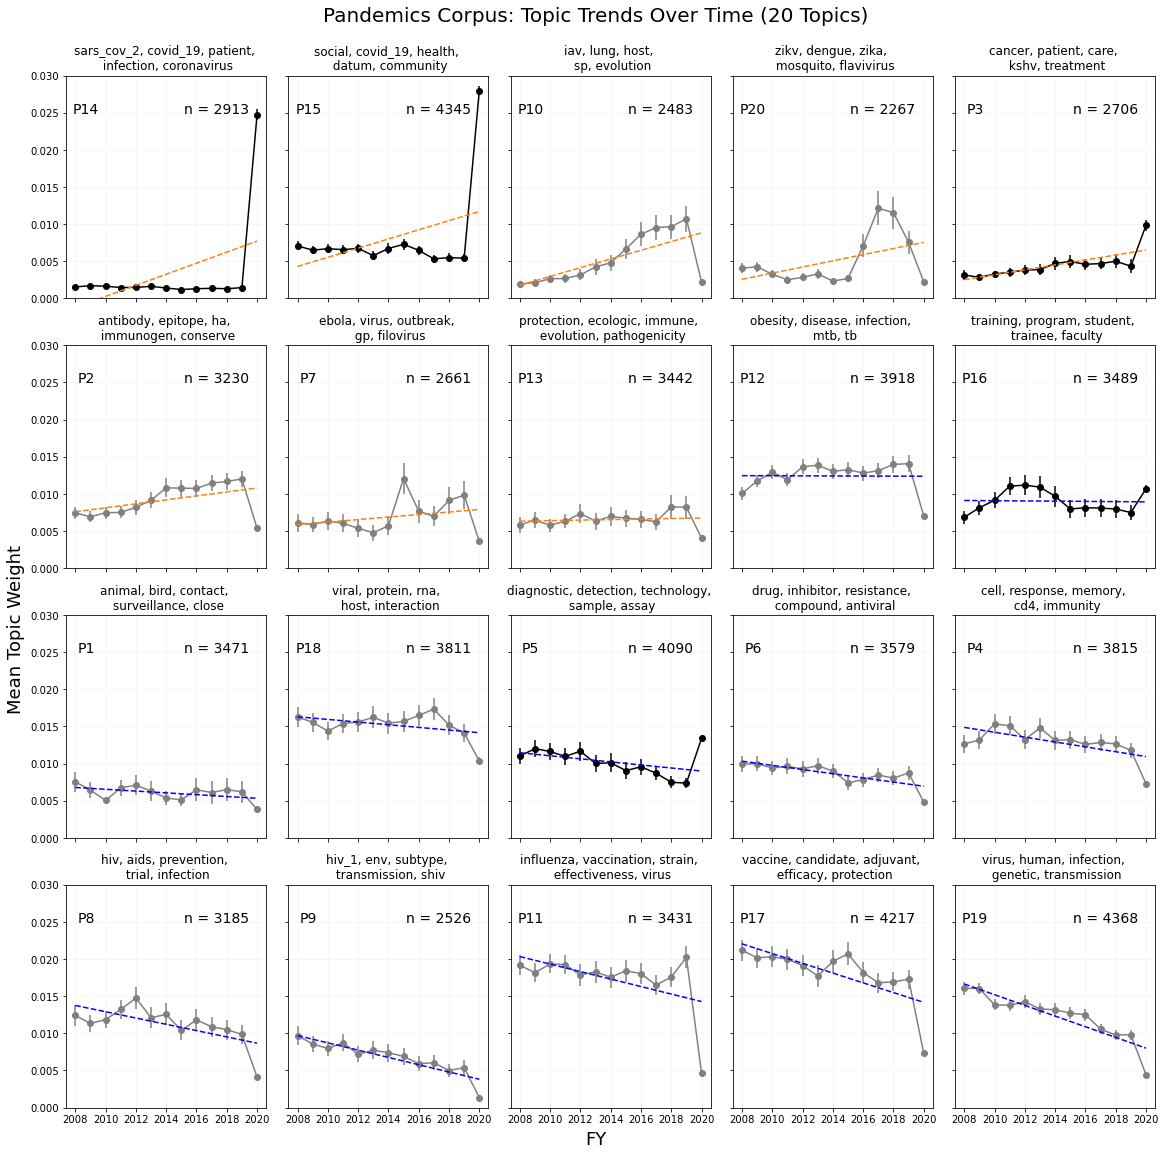

In [93]:
# set up grid
fig, ax = plt.subplots(4, 5, sharex = True, sharey = True, figsize=(16,16))
plt.ylim(bottom = 0.00, top = 0.03) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in [0,1,4,9,12]): # upward trend in 2020
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[i,j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[i,j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Pandemics Corpus: Topic Trends Over Time (20 Topics)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.savefig("./figures/pan_20topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/pan_20topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

### Descriptive statistics on corpus

In [49]:
df["FY"].value_counts().sort_index()

2008     479
2009     549
2010     545
2011     532
2012     442
2013     412
2014     388
2015     433
2016     440
2017     450
2018     452
2019     457
2020    1992
Name: FY, dtype: int64

In [50]:
df["DEPARTMENT"].value_counts()

HHS     6473
NSF      869
USDA     189
DOD       24
VA        11
NASA       3
EPA        2
Name: DEPARTMENT, dtype: int64

In [51]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["FY"] = filt_df["FY"].astype('int')

filt_df = filt_df[filt_df["FY"] >= year_st]
filt_df = filt_df[filt_df["FY"] <= year_end]

In [52]:
year_counts = filt_df["FY"].value_counts().sort_index()
print(year_counts)

2008     479
2009     549
2010     545
2011     532
2012     442
2013     412
2014     388
2015     433
2016     440
2017     450
2018     452
2019     457
2020    1992
Name: FY, dtype: int64


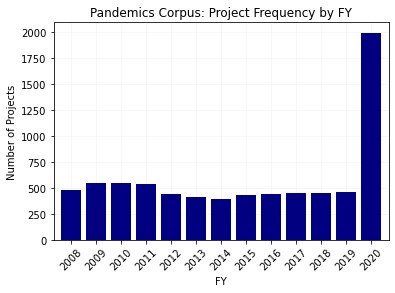

In [58]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
plt.xlim(2007.3,2020.7)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Pandemics Corpus: Project Frequency by FY");

plt.savefig("./figures/pan_startyr_freq.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/pan_startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

In [59]:
agency_counts = filt_df["DEPARTMENT"].value_counts()
print(agency_counts)

HHS     6473
NSF      869
USDA     189
DOD       24
VA        11
NASA       3
EPA        2
Name: DEPARTMENT, dtype: int64


In [61]:
len(filt_df)

7571

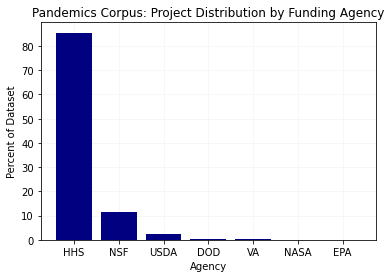

In [64]:
# plot
agency = agency_counts.index.tolist()
pct = 100*agency_counts.values/len(filt_df)

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, pct, color='navy')
plt.xlabel("Agency")
plt.ylabel("Percent of Dataset")
plt.title("Pandemics Corpus: Project Distribution by Funding Agency");

#plt.savefig("./figures/pan_agency_dist.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_agency_dist.pdf", dpi = 800, bbox_inches = "tight")

In [65]:
filt_df.pivot_table(index=['DEPARTMENT','FY'], aggfunc='size')

DEPARTMENT  FY  
DOD         2009       1
            2013       2
            2014       2
            2016       3
            2017      11
            2018       5
EPA         2012       1
            2015       1
HHS         2008     447
            2009     505
            2010     512
            2011     502
            2012     412
            2013     390
            2014     368
            2015     394
            2016     414
            2017     417
            2018     430
            2019     439
            2020    1243
NASA        2009       1
            2012       1
            2015       1
NSF         2008      15
            2009      17
            2010      14
            2011      10
            2012       9
            2013       6
            2014       5
            2015      19
            2016      11
            2017       8
            2018       3
            2019       5
            2020     747
USDA        2008      17
            2009      24
        

In [66]:
filt_df.shape

(7571, 30)